In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import gc
import time

In [2]:
PICKLES_PATH = './pickles/'
CKPT_PATH = './ckpt/'
NUM_LABELS = 11
DIGITS_SEQ = 5 #digits sequence length
IMAGE_SIZE = 32
NUM_CHANNELS = 1 # grayscale
BATCH_SIZE = 64
EVAL_BATCH_SIZE = 256

In [3]:
pickle_file = PICKLES_PATH +'SVHN_train-valid-test_norm_noextra.pickle'

with open(pickle_file, 'rb') as f:
  load = pickle.load(f)
  X_train = load['X_train']
  y_train = load['y_train']
  X_valid = load['X_valid']
  y_valid = load['y_valid']
  X_test = load['X_test']
  y_test = load['y_test']
  del load

print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (33401, 32, 32, 1) (33401, 6)
Validation set (5500, 32, 32, 1) (5500, 6)
Test set (13068, 32, 32, 1) (13068, 6)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 2).T == labels) / predictions.shape[1] 
          / predictions.shape[0])

In [7]:
PATCH_SIZE = 3
depth1 = 16
depth2 = 32
depth3 = 64
num_hidden1 = 256
num_hidden2 = 16
shape=[BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS]

LEARN_RATE = 0.03 # initial learning rate
DROPOUT = 0.55 # dropout keep probability

# Construct a 6-layer CNN.
# C1: convolutional layer, batch_size x 32 x 32 x 16, convolution size: 3 x 3 x 1 x 16
# C2: convolutional layer, batch_size x 32 x 32 x 16, convolution size: 3 x 3 x 1 x 16
# S1: sub-sampling layer, batch_size x 16 x 16 x 16
# C3: convolutional layer, batch_size x 14 x 14 x 32, convolution size: 3 x 3 x 1 x 32
# C4: convolutional layer, batch_size x 12 x 12 x 32, convolution size: 3 x 3 x 1 x 32
# S4: sub-sampling layer, batch_size x 6 x 6 x 32
# C5: convolutional layer, batch_size x 4 x 4 x 64, convolution size: 3 x 3 x 1 x 64
# C6: convolutional layer, batch_size x 2 x 2 x 64, convolution size: 3 x 3 x 1 x 64
# Dropout
# F1: fully-connected layer, weight size: 256 x 16
# Output layer, weight size: 16 x 10

graph = tf.Graph()


with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
        tf.float32,
        shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  tf_train_labels = tf.placeholder(
        tf.int64,
        shape=(BATCH_SIZE,6))
  eval_data = tf.placeholder(
        tf.float32,
        shape=(EVAL_BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
  
  # Variables.
  conv1_weights = tf.get_variable(
        "W1",
        shape=[PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS, depth1],
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv1_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B1')
  conv2_weights = tf.get_variable(
        "W2",
        shape=[PATCH_SIZE, PATCH_SIZE, depth1, depth1],
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv2_biases = tf.Variable(tf.constant(1.0, shape=[depth1]), name='B2')
  conv3_weights = tf.get_variable(
        "W3",
        shape=[PATCH_SIZE, PATCH_SIZE, depth1, depth2],\
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv3_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B3')
  conv4_weights = tf.get_variable(
        "W4",
        shape=[PATCH_SIZE, PATCH_SIZE, depth2, depth2],
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv4_biases = tf.Variable(tf.constant(1.0, shape=[depth2]), name='B4')
  conv5_weights = tf.get_variable(
        "W5",
        shape=[PATCH_SIZE, PATCH_SIZE, depth2, depth3],
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv5_biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B5')
  conv6_weights = tf.get_variable(
        "W6",
        shape=[PATCH_SIZE, PATCH_SIZE, depth3, depth3],
        initializer=tf.contrib.layers.xavier_initializer_conv2d())
  conv6_biases = tf.Variable(tf.constant(1.0, shape=[depth3]), name='B6')

  s1_w = tf.get_variable("WS1", shape=[num_hidden1, NUM_LABELS],\
           initializer=tf.contrib.layers.xavier_initializer())
  s1_b = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='BS1')
  s2_w = tf.get_variable("WS2", shape=[num_hidden1, NUM_LABELS],\
           initializer=tf.contrib.layers.xavier_initializer())
  s2_b = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='BS2')
  s3_w = tf.get_variable("WS3", shape=[num_hidden1, NUM_LABELS],\
           initializer=tf.contrib.layers.xavier_initializer())
  s3_b = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='BS3')
  s4_w = tf.get_variable("WS4", shape=[num_hidden1, NUM_LABELS],\
           initializer=tf.contrib.layers.xavier_initializer())
  s4_b = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='BS4')
  s5_w = tf.get_variable("WS5", shape=[num_hidden1, NUM_LABELS],\
           initializer=tf.contrib.layers.xavier_initializer())
  s5_b = tf.Variable(tf.constant(1.0, shape=[NUM_LABELS]), name='BS5')
  
  # Model.
  def model(data, keep_prob, shape):
    #LCN = LecunLCN(data, shape)
    #tf.Print(LecunLCN(data, shape), [LecunLCN(data, shape),data])
    
    #conv = tf.nn.conv2d(LCN, conv1_weights, [1,1,1,1], 'SAME', name='C1')
    
    conv = tf.nn.conv2d(data, conv1_weights, [1,1,1,1], 'SAME', name='C1')
    hidden = tf.nn.relu(conv + conv1_biases)
    conv = tf.nn.conv2d(hidden, conv2_weights, [1,1,1,1], 'SAME', name='C2')
    hidden = tf.nn.relu(conv + conv2_biases)
    
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S1')
    
    conv = tf.nn.conv2d(sub, conv3_weights, [1,1,1,1], padding='VALID', name='C3')
    hidden = tf.nn.relu(conv + conv3_biases)
    conv = tf.nn.conv2d(hidden, conv4_weights, [1,1,1,1], padding='VALID', name='C4')
    hidden = tf.nn.relu(conv + conv4_biases)
    
    lrn = tf.nn.local_response_normalization(hidden)
    sub = tf.nn.max_pool(lrn, [1,2,2,1], [1,2,2,1], 'SAME', name='S2')
    
    conv = tf.nn.conv2d(sub, conv5_weights, [1,1,1,1], padding='VALID', name='C5')
    hidden = tf.nn.relu(conv + conv5_biases)
    conv = tf.nn.conv2d(hidden, conv6_weights, [1,1,1,1], padding='VALID', name='C6')
    hidden = tf.nn.relu(conv + conv6_biases)    
    
    hidden = tf.nn.dropout(hidden, keep_prob)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    
    s1_logit = tf.matmul(reshape, s1_w) + s1_b
    s2_logit = tf.matmul(reshape, s2_w) + s2_b
    s3_logit = tf.matmul(reshape, s3_w) + s3_b
    s4_logit = tf.matmul(reshape, s4_w) + s4_b
    s5_logit = tf.matmul(reshape, s5_w) + s5_b    
    return [s1_logit, s2_logit, s3_logit, s4_logit, s5_logit]
  
  # Training computation.
  [s1_logit, s2_logit, s3_logit, s4_logit, s5_logit] = model(tf_train_dataset, DROPOUT, shape)
    
 
  loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s1_logit, labels=tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s2_logit, labels=tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s3_logit, labels=tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s4_logit, labels=tf_train_labels[:,4])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=s5_logit, labels=tf_train_labels[:,5]))
    
  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(LEARN_RATE, global_step, 100000, 0.96, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  

  # Predictions for the training and evaluation data
  def softmax_combine(dataset, shape):
    train_prediction = tf.stack([
        tf.nn.softmax(model(dataset, 1.0, shape)[0]),
        tf.nn.softmax(model(dataset, 1.0, shape)[1]),
        tf.nn.softmax(model(dataset, 1.0, shape)[2]),
        tf.nn.softmax(model(dataset, 1.0, shape)[3]),
        tf.nn.softmax(model(dataset, 1.0, shape)[4])])
    return train_prediction

  train_prediction = softmax_combine(tf_train_dataset, shape)
  eval_prediction = softmax_combine(eval_data, shape)
  
    
  def eval_in_batches(data, sess):
    """Get all predictions for a dataset by running it in small batches."""
    size = data.shape[0]
    if size < EVAL_BATCH_SIZE:
      raise ValueError("batch size for evals larger than dataset: %d" % size)
    predictions = np.ndarray(shape=(5, size, NUM_LABELS), dtype=np.float32)
    for begin in xrange(0, size, EVAL_BATCH_SIZE):
      end = begin + EVAL_BATCH_SIZE
      if end <= size:
        predictions[:,begin:end, :] = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[begin:end, ...]})
      else:
        batch_predictions = sess.run(
            eval_prediction,
            feed_dict={eval_data: data[-EVAL_BATCH_SIZE:, ...]})
        predictions[:,begin:, :] = batch_predictions[:,begin - size:, :]
    return predictions
    
  saver = tf.train.Saver()

In [8]:
num_steps = 5001
EVAL_FREQUENCY = 500

t0 = time.time()

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * BATCH_SIZE) % (y_train.shape[0] - BATCH_SIZE)
    batch_data = X_train[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = y_train[offset:(offset + BATCH_SIZE),:]
    feed_dict = {
        tf_train_dataset : batch_data, 
        tf_train_labels : batch_labels
    }
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if step % EVAL_FREQUENCY == 0: 
      batch_accur = accuracy(predictions, batch_labels[:,1:6])
      valid_accur = accuracy(eval_in_batches(X_valid, session), y_valid[:,1:6])
      duration = time.time() - t0
      print("%d %f %.1f %.1f %.1f" % (step, l, batch_accur, valid_accur, duration))
        
      t0 = time.time()
  
  print('Test accuracy: %.1f%%' % accuracy(eval_in_batches(X_test, session), y_test[:,1:6]))
  
  save_path = saver.save(session, CKPT_PATH + "my-model-100000.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
0 20.982611 3.8 53.3 7.2
500 6.193752 61.6 52.5 134.8
1000 5.516593 63.4 52.5 127.7
1500 5.602228 67.5 55.3 124.6
2000 5.172976 66.9 60.0 139.8
2500 3.950008 76.2 66.8 129.2
3000 4.066281 76.9 72.8 123.1
3500 2.740778 85.6 77.2 142.4
4000 2.679473 86.2 79.0 145.4
4500 2.425508 87.2 83.0 140.8
5000 2.711002 84.7 84.6 129.4
Test accuracy: 90.0%
Model saved in file: ./ckpt/my-model-100000.ckpt


In [11]:
with tf.Session(graph=graph) as session:
  # Use TensorFlow to find the latest checkpoint - if any.
  last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=CKPT_PATH)

  # Try and load the data in the checkpoint.
  saver.restore(session, save_path=last_chk_path)
  print('Session restored')
  
  y_test_predictions = eval_in_batches(X_test, session)

INFO:tensorflow:Restoring parameters from ./ckpts/my-model-100000.ckpt
Session restored


In [12]:
test_prediction = np.argmax(y_test_predictions, 2).T

In [13]:
print (test_prediction)

[[ 4  0 10 10 10]
 [ 6 10 10 10 10]
 [ 1  0  7  2 10]
 ..., 
 [ 4  0 10 10 10]
 [ 1  5 10 10 10]
 [ 3 10 10 10 10]]


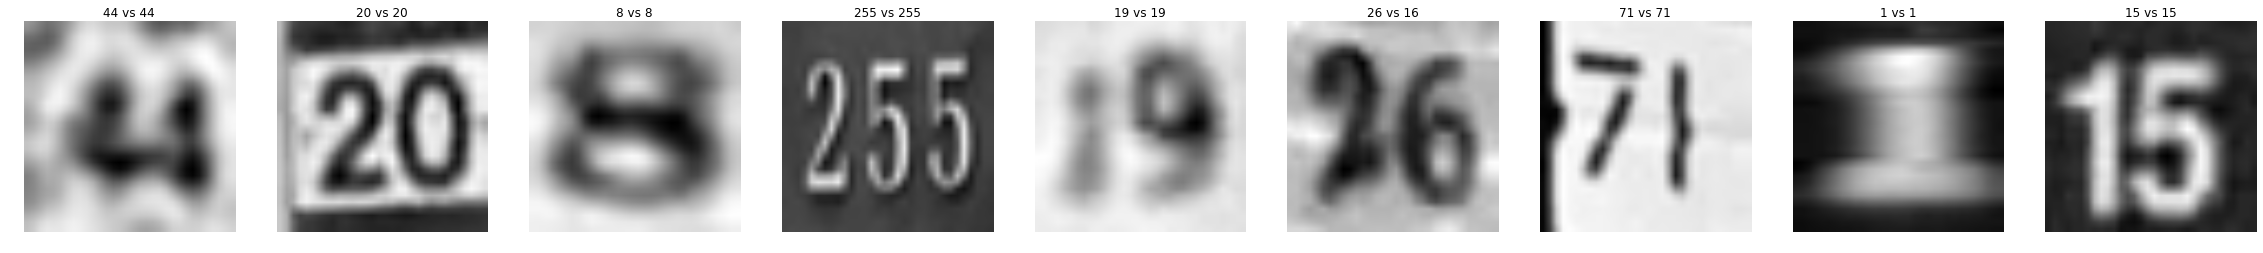

In [14]:
from PIL import Image
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (40.0, 40.0)
f, ax = plt.subplots(nrows=1, ncols=9)

im_samples = []
    
for i, j in enumerate(np.sort(np.random.randint(0, X_test.shape[0], size=9))):
    house_num = ''
    for k in range(5):
        num = y_test[j,k+1]        
        if num < 10:        
            house_num += str(num)
    house_num += " vs "
    for k in range(5):
        num = test_prediction[j,k]
        if num < 10:        
            house_num += str(num)
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(house_num, loc='center')
    ax[i].imshow(X_test[j,:,:,0], cmap='gray')